<a href="https://colab.research.google.com/github/shree180103/food_vision_mini/blob/main/fodd_vision_mini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn


In [2]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# get data

First things first we need some data.

And like any good cooking show, some data has already been prepared for us.

We're going to start small.

Because we're not looking to train the biggest model or use the biggest dataset yet.

Machine learning is an iterative process, start small, get something working and increase when necessary.

The data we're going to be using is a subset of the Food101 dataset.

Food101 is popular computer vision benchmark as it contains 1000 images of 101 different kinds of foods, totaling 101,000 images (75,750 train and 25,250 test).

Can you think of 101 different foods?

Can you think of a computer program to classify 101 foods?

I can.

A machine learning model!

Specifically, a PyTorch computer vision model like we covered in notebook 03.

Instead of 101 food classes though, we're going to start with 3: pizza, steak and sushi.

And instead of 1,000 images per class, we're going to start with a random 10% (start small, increase when necessary).

If you'd like to see where the data came from you see the following resources:

Original Food101 dataset and paper website.
torchvision.datasets.Food101 - the version of the data I downloaded for this notebook.
extras/04_custom_data_creation.ipynb - a notebook I used to format the Food101 dataset to use for this notebook.
data/pizza_steak_sushi.zip - the zip archive of pizza, steak and sushi images from Food101, created with the notebook linked above.
Let's write some code to download the formatted data from GitHub.

Note: The dataset we're about to use has been pre-formatted for what we'd like to use it for. However, you'll often have to format your own datasets for whatever problem you're working on. This is a regular practice in the machine learning world.

In [5]:
import requests
import zipfile
from pathlib import Path

# set up to a data folder
data_path=Path("data/")
image_path=data_path/ "pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} already exits...skipping download ")
else:
  print(f" {image_path} does not exist.... crearing one ")
  image_path.mkdir(parents=True,exist_ok=True)

# download pizza sushi and steak data
with open(data_path/"pizza_steak_sushi.zip","wb") as f:
  request=requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("downloading pizza steak and sudhi data ")
  f.write(request.content)

#unzip data
with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip","r") as zip_ref:
  print("unzipping pizza steak and sushi data")
  zip_ref.extractall(image_path)


data/pizza_steak_sushi already exits...skipping download 
downloading pizza steak and sudhi data 
unzipping pizza steak and sushi data


# data prep


In [6]:
import os
def walk_thru_dirc(dir_path):
  for dirpath,dirnames,filenames in os.walk(dir_path):
    print(f"there are {len(dirnames)} dircectories and {len(filenames)} images in {dirpath}")


In [7]:
walk_thru_dirc(image_path)

there are 2 dircectories and 0 images in data/pizza_steak_sushi
there are 3 dircectories and 0 images in data/pizza_steak_sushi/test
there are 0 dircectories and 19 images in data/pizza_steak_sushi/test/steak
there are 0 dircectories and 25 images in data/pizza_steak_sushi/test/pizza
there are 0 dircectories and 31 images in data/pizza_steak_sushi/test/sushi
there are 3 dircectories and 0 images in data/pizza_steak_sushi/train
there are 0 dircectories and 75 images in data/pizza_steak_sushi/train/steak
there are 0 dircectories and 78 images in data/pizza_steak_sushi/train/pizza
there are 0 dircectories and 72 images in data/pizza_steak_sushi/train/sushi


In [8]:
# training and test path
train_dir=image_path/ "train"
test_dir=image_path/ "test"
train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [9]:
# visualize an img
import random
from PIL import Image

random.seed(42)

#get all the img paths
image_path_list=list(image_path.glob("*/*/*.jpg"))

image_path_list



[PosixPath('data/pizza_steak_sushi/test/steak/1302563.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/673127.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/966174.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1882831.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/3873283.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1285886.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/690177.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/354513.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/3424937.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/2144308.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/2117351.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/27415.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1627703.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/502076.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/894825.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/100274.jpg'),
 PosixPath('data/pizza_steak_sush

In [24]:
# pick a random img path
# random.seed(42)
random_image_path=random.choice(image_path_list)

print(random_image_path)

# get image class from path name (the img class is the name of the dircetory where the img is stored)
image_class=random_image_path.parent.stem

print(image_class)


data/pizza_steak_sushi/test/sushi/2540511.jpg
sushi


Random image path:data/pizza_steak_sushi/test/sushi/2540511.jpg
Image class:sushi
Image height:512
Image width:512


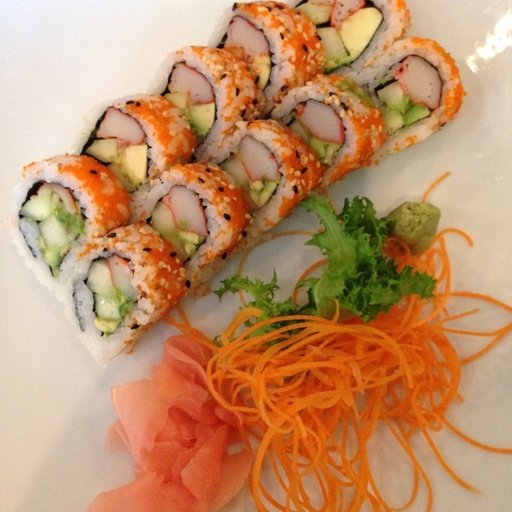

In [25]:
img=Image.open(random_image_path)
print(f"Random image path:{random_image_path}")
print(f"Image class:{image_class}")
print(f"Image height:{img.height}")
print(f"Image width:{img.width}")
img

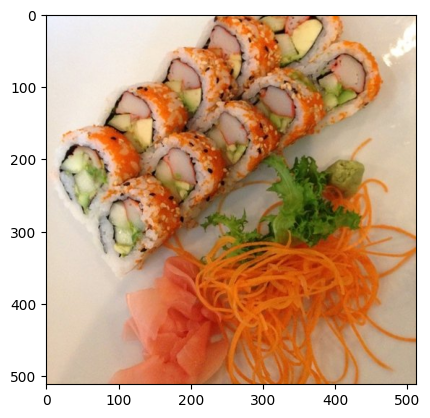

In [28]:
import numpy as np
import matplotlib.pyplot as plt
plt.imshow(img)

(512, 512, 3)


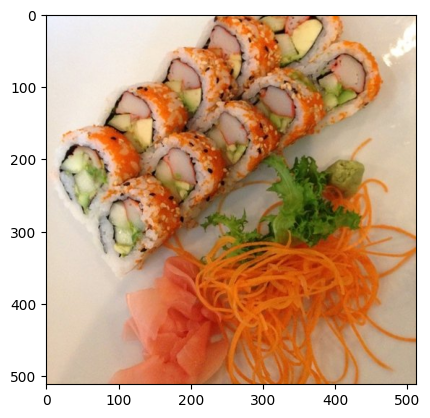

In [30]:
img_as_arr=np.asarray(img)
print(img_as_arr.shape)
plt.imshow(img_as_arr)

In [31]:
# tranforming imgs into tensors

from torch.utils.data import DataLoader
from torchvision import datasets,transforms
